In [1]:
import pickle
import numpy as np
import torch
from sklearn import linear_model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(8, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [20]:
with open('painting_code_dictionary.pkl', 'rb') as f:
    painting_code_dictionary = pickle.load(f)

In [21]:
years = painting_code_dictionary.keys()

labels = []
codes = np.zeros((1, 128))

for year in list(years):
    
    painting_indexes = painting_code_dictionary[year].keys()
    
    for painting_index in list(painting_indexes):
        
        code = painting_code_dictionary[year][painting_index].detach().numpy()
        
        code = code.reshape(1, 128)

        labels.append(int(year))
        
        codes = np.concatenate((codes, code), axis = 0)
        
codes = codes[0:codes.shape[0] - 1, :]

labels = np.array(labels)

In [22]:
coefficients = []
intercepts = []

for unit in range(128):

    unit_activations = codes[:, unit]

    regr = linear_model.LinearRegression()

    regr.fit(labels.reshape(-1, 1), unit_activations)
    
    coefficient = regr.coef_
    intercept = regr.intercept_
    
    coefficients.append(coefficient[0])
    intercepts.append(intercept)
    

In [23]:
predicted_codes = np.zeros((1, 128))

for year in range(1850, 1950):
    
    coefficient_term = [coefficient * year for coefficient in coefficients]
    intercept_term = intercepts
    
    code = np.array(coefficient_term) + np.array(intercept_term)
    
    predicted_codes = np.concatenate((codes, code.reshape(1, -1)), axis = 0)

In [24]:
device = get_default_device()

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [25]:
generator.load_state_dict(torch.load('trained_generator.pth'))

<All keys matched successfully>

In [26]:
#average evolution of style

images = []

for year in range(101):
    
    code = predicted_codes[year, :]
    tensor_code = torch.from_numpy(code)
    tensor_code = torch.reshape(tensor_code, (1, 128, 1, 1))

    fake_image = generator(tensor_code.float())
    numpy_image = np.squeeze(fake_image.detach().numpy())
    transposed_image = np.transpose(numpy_image, (1, 2, 0))
    denormed_image = denorm(transposed_image)
    
    denormed_image = denormed_image * 255
    denormed_image = denormed_image.astype(np.uint8)
    images.append(Image.fromarray(denormed_image))
    
fp_out = 'evolution.gif'

img = images[0]  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=images,
         save_all=True, duration=500, loop=0)

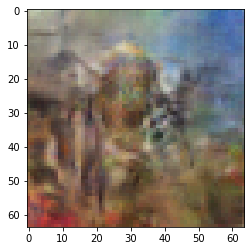

In [43]:
#view target image
code = painting_code_dictionary['1889'][164]
fake_image = generator(code.float())
numpy_image = np.squeeze(fake_image.detach().numpy())
transposed_image = np.transpose(numpy_image, (1, 2, 0))
denormed_image = denorm(transposed_image)
plt.imshow(denormed_image)

In [53]:
#evolution of style through target painting

target_code = painting_code_dictionary['1889'][164]
target_code = target_code.reshape(128)
predicted_code = predicted_codes[year, :]
correction = target_code.detach().numpy() - predicted_code

images = []

for year in range(101):
    
    code = predicted_codes[year, :] + correction
    tensor_code = torch.from_numpy(code)
    tensor_code = torch.reshape(tensor_code, (1, 128, 1, 1))

    fake_image = generator(tensor_code.float())
    numpy_image = np.squeeze(fake_image.detach().numpy())
    transposed_image = np.transpose(numpy_image, (1, 2, 0))
    denormed_image = denorm(transposed_image)
    
    denormed_image = denormed_image * 255
    denormed_image = denormed_image.astype(np.uint8)
    images.append(Image.fromarray(denormed_image))
    
fp_out = 'evolution_through_target.gif'

img = images[0]  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=images,
         save_all=True, duration=500, loop=0)